In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def imagem_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

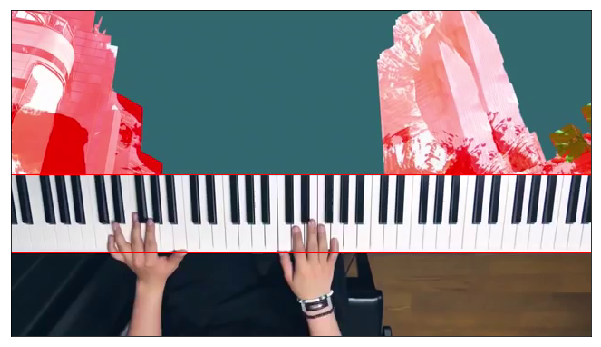

In [3]:
image = cv2.imread("piano2.png")
(h, w, c) = image.shape

# Marcar corte
hi, hf = 182, 268
cropped_preview = image.copy()
cv2.line(cropped_preview, (0, hi), (w-1, hi), (0, 0, 255), 1)
cv2.line(cropped_preview, (0, hf), (w-1, hf), (0, 0, 255), 1)

imagem_plot(cv2.cvtColor(cropped_preview, cv2.COLOR_BGR2RGB))

cropped = image[hi:hf,:,:]

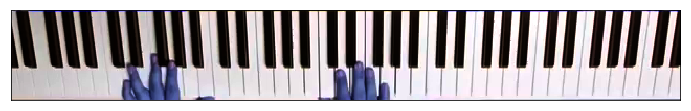

In [4]:
normalized = cropped.astype('float32') / cropped.max()

# Gamma
normalized = normalized ** 2



cropped = (normalized * 255).astype('uint8')
imagem_plot(cropped)

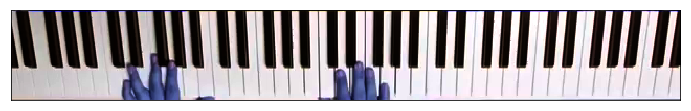

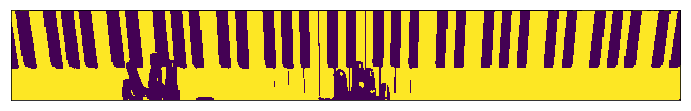

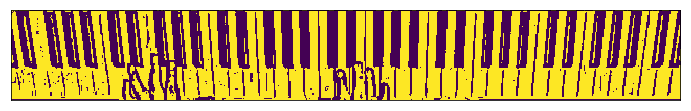

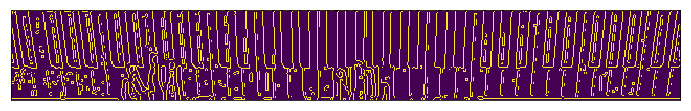

In [7]:
imagem_plot(cropped)

grayscale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# Binarizar
ret, thresh = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
imagem_plot(thresh)
thresh = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
imagem_plot(thresh)

# Bordas
edges = cv2.Canny(thresh, 200, 300)
imagem_plot(edges)

In [6]:
# Ransac